# Model Evaluation
### Beatrice Brown-Mulry

---
## Contents:
- **0. Model Inference**
- **1. Evaluation Metrics**
- **2. Subgroup Evaluation**
- **3. Modeling Best Practices**

---
# 0. Loading our Predictions

You should be using the `pandas` environment. The only packages you should need to download are `scikit-learn` (`sklearn`) and `statsmodel` which are shown below.

In [106]:
%pip install scikit-learn
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import auc, RocCurveDisplay, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def dataframe_stats(df, title: str or None = None):
    """
    helper function to check the number of patients, exams, and images/findings in a df
    """
    if title is not None:
        print(f"\n{title}")
        
    num_patients = df.empi_anon.nunique()
    num_exams = df.acc_anon.nunique()
    
    print(f"Patients: {num_patients}")
    print(f"Exams: {num_exams}")
    
    if 'png_path' in df.columns:
        print(f"Images: {df.png_path.nunique()}\n")
    else:
        print(f"Findings: {len(df)}\n")

In [3]:
inference_df = pd.read_csv('./datasets/embed_demo_result_complete.csv')

col_dict = {'scores': 'prediction', 'session_label': 'truth'}
inference_df.rename(columns=col_dict, inplace=True)
inference_df

,png_path,prediction,truth
0,/fsx/embed/emory-mammo/images/png/cohort_10/ex...,0.426943,1
1,/fsx/embed/emory-mammo/images/png/cohort_10/ex...,0.469375,1
2,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,0.288646,1
3,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,0.307292,1
4,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,0.309218,1
...,...,...,...
18894,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,0.391145,0
18895,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,0.346059,0
18896,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,0.319508,0
18897,/fsx/embed/emory-mammo/images/png/cohort_1/ext...,0.371289,0


In [4]:
test_path_list = inference_df['png_path'].unique().tolist()

In [5]:
REBUILD_TEST_SET = False

# rebuild our test set if necessary (otherwise just load it)
if REBUILD_TEST_SET:
    # load our original data in
    pos_df = pd.read_csv('./datasets/POSITIVE_BR0_GROUP.csv')
    pos_df['label'] = 1
    neg_df = pd.read_csv('./datasets/NEGATIVE_BR12_GROUP.csv')
    neg_df['label'] = 0
    
    # concat our pos/neg sets
    test_df = pd.concat([pos_df, neg_df])
    # then drop any duplicate pngs
    test_df.drop_duplicates(subset='png_path', inplace=True)
    # and only retain images from the test set
    test_df = test_df[test_df.png_path.isin(test_path_list)]
    test_df.reset_index(inplace=True)
    test_df.to_csv('./datasets/br0_vs_br12_test.csv', index=False)
    
else:
    test_df = pd.read_csv('./datasets/br0_vs_br12_test.csv')

dataframe_stats(test_df, 'test set')


test set
Patients: 4918
Exams: 4918
Images: 18899



/tmp/ipykernel_61315/2356673095.py:21: DtypeWarning: Columns (8,9,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('./datasets/br0_vs_br12_test.csv')


### Let's check our test set class balance

In [6]:
test_df.label.value_counts(dropna=False)

label
0    12146
1     6753
Name: count, dtype: int64

In [7]:
test_df.label.value_counts(dropna=False, normalize=True)

label
0    0.64268
1    0.35732
Name: proportion, dtype: float64

### Now we have our test set and our predictions ready, we can index our predictions back to the original data so we can further analyze our results

In [8]:
# merge on our image-level index (png_path in this case)
test_preds_df = test_df.merge(inference_df, on='png_path', how='inner')
test_preds_df

,index,empi_anon,acc_anon,study_date_anon_x,desc,side,asses,path_severity,bside,procdate_anon,...,anon_dicom_path,StudyDescription,ROI_match_level,num_roi,PNG_ROI_coords,DCM_ROI_coords,spot_mag,label,prediction,truth
0,0,10010842,2152357467079057,2014-07-05,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,4.0,L,2014-07-18,...,/fsx/embed/emory-mammo/images/dicom/cohort_10/...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[],0.0,[],NaN,NaN,1,0.426943,1
1,1,10010842,2152357467079057,2014-07-05,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,4.0,L,2014-07-18,...,/fsx/embed/emory-mammo/images/dicom/cohort_10/...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[],0.0,[],NaN,NaN,1,0.469375,1
2,18,10044241,3993319361430024,2019-07-27,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,...,/fsx/embed/emory-mammo/images/dicom/cohort_1/1...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[],0.0,[],NaN,NaN,1,0.288646,1
3,19,10044241,3993319361430024,2019-07-27,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,...,/fsx/embed/emory-mammo/images/dicom/cohort_1/1...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[['1']],1.0,"[[[1561, 864, 3182, 1753]]]","[[[1561, 864, 3182, 1753]]]",NaN,1,0.307292,1
4,20,10044241,3993319361430024,2019-07-27,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,A,NaN,NaN,NaN,...,/fsx/embed/emory-mammo/images/dicom/cohort_1/1...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[['1']],1.0,"[[[892, 298, 2319, 1477]]]","[[[892, 298, 2319, 1477]]]",NaN,1,0.309218,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18894,61088,99986224,7287112295028243,2016-05-18,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,N,NaN,NaN,NaN,...,/fsx/embed/emory-mammo/images/dicom/cohort_1/9...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[],0.0,[],NaN,NaN,0,0.391145,0
18895,61089,99986224,7287112295028243,2016-05-18,MG Screen Bilat w/Tomo/CAD Stnd Protocol,L,N,NaN,NaN,NaN,...,/fsx/embed/emory-mammo/images/dicom/cohort_1/9...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[],0.0,[],NaN,NaN,0,0.346059,0
18896,61090,99986224,7287112295028243,2016-05-18,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R,N,NaN,NaN,NaN,...,/fsx/embed/emory-mammo/images/dicom/cohort_1/9...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[],0.0,[],NaN,NaN,0,0.319508,0
18897,61091,99986224,7287112295028243,2016-05-18,MG Screen Bilat w/Tomo/CAD Stnd Protocol,R,N,NaN,NaN,NaN,...,/fsx/embed/emory-mammo/images/dicom/cohort_1/9...,MG Screen Bilat w/Tomo/CAD Stnd Protocol,[],0.0,[],NaN,NaN,0,0.371289,0


---
# 1.0 Evaluation Metrics

The following metrics are generally appropriate for evaluating binary classification tasks. Multiclass or multi-label classification commonly uses similar metrics but many are adjusted or calculated for each class and averaged. Other modeling tasks such as segmentation commonly use metrics like DICE or the Jaccard index (also known as the Intersection over Union (IoU)). There are countless different evaluation metrics but we'll review some of the most common examples.

Many of the most common metrics are thresholded, so we'll first define an arbitrary threshold (0.5 in this case) and use it to binarize our predictions. We'll define any probabilities above 0.5 as positive predictions (coded as 1), and all values equal to or below 0.5 as negative predictions (coded as 0).

These binary predictions can then be used to determine whether each prediction is a true positive (TP), true negative (TN), false positive (FP), or false negative (FN). These classifications are often used to determine error rates like the false positive rate (FPR) or false negative rate (FNR) which can be useful for evaluating model failure modes.

> **Question: What are false positives (FP) and false negatives (FN) in the context of a breast cancer classification model?**

> **Question: Depending on the context, are all error types equally severe?**

## 1.1 Confusion Matrices

![conf_matrix_example](images/conf_matrix_example.png)

## 1.2 Accuracy

### $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

**Accuracy** is a commonly used metric and one of the easiest to understand. In simple terms it expresses the percentage of observations that were classified correctly. It can be calculated by dividing the number of true predictions by the total number of predictions.

> **Question: Is high accuracy always a sign of a good model? Are there any situations where high accuracy can be misleading?**

In [9]:
def get_accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn)

## 1.3 Precision/Recall

### $\text{Precision} = \frac{TP}{TP + FP}$
### $\text{Recall} = \frac{TP}{TP + FN}$

**Precision** measures what proportion of positive predictions were actually positive. It can be calculated by dividing the number of true positives by the total number of positive predictions (true positives and false positives). A high precision indicates that most of your models positive predictions are *actually* positive.

**Recall** is also known as **Sensitivity**, **True Positive Rate (TPR)**, or the **probability of detection**. Recall is calculated by dividing the number of true positives (correctly classified positives) by the total number of positives (both true positives and positives that were misclassified as negative). It expresses how many of the actual positives were correctly classified as positive. A high recall indicates that your model correctly predicted most observations in the positive class.

> **Question: Your model has high precision but low recall. What might this suggest about the model's performance?**

> **Question: Conversely, what could a high recall and low precision suggest?**

The interactive demo on the page below demonstrates the (generally!) inverse relationship between precision and recall.
https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall

In [10]:
def get_precision(tp, tn, fp, fn, eps=1e-7):
    return tp / (tp + fp + eps)

def get_recall(tp, tn, fp, fn, eps=1e-7):
    return tp / (tp + fn + eps)

## 1.4 F1 Score

### $\text{F1} = \frac{2 * Precision * Recall}{Precision + Recall}$

The **F1 score** is the harmonic mean of the precision and recall. It can offer a more-comprehensive view of model performance than precision or recall alone by capturing the tradeoff between them. F1 score is fairly resilient to imbalanced data and can be a good choice compared to alternatives like accuracy.

> BEA INPUT !!!: EXPAND ON THIS, DISCUSS MACRO vs MICRO AVERAGED F1

In [11]:
def get_f1(prec, rec, eps=1e-7):
    return (2 * prec * rec)/(prec + rec + eps)

## 1.5 Sensitivity/Specificity

### $\text{Sensitivity} = \frac{TP}{TP + FN}$
### $\text{Specificity} = \frac{TN}{TN + FP}$

In [12]:
def get_sensitivity(tp, tn, fp, fn, eps=1e-7):
    return tp / (tp + fn + eps)

def get_specificity(tp, tn, fp, fn, eps=1e-7):
    return tn / (tn + fp + eps)

## 1.6 AUROC

The **AUROC**, or **Area Under the Receiver Operating Curve** is commonly referred to as the **AUC**. Unlike metrics like accuracy, precision, recall, and others, the AUROC does not depend on a single threshold to classify probabilities. Instead it captures how the variance of model performance at different threshold levels. It's commonly used, but can be misleading in some cases since it doesn't capture the classification performance at a single chosen threshold.

> **Question: Your model has a high AUROC but a low accuracy, what might this suggest?**

auroc: 0.629


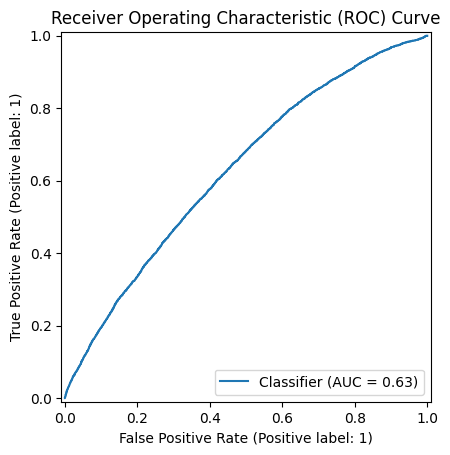

In [13]:
def get_auroc(truth, preds):
    roc_fpr, roc_tpr, _ = roc_curve(truth, preds)
    return auc(roc_fpr, roc_tpr)

display = RocCurveDisplay.from_predictions(
    test_preds_df.truth, # truth
    test_preds_df.prediction # predicted probabilities
)
_ = display.ax_.set_title("Receiver Operating Characteristic (ROC) Curve")

auroc = get_auroc(test_preds_df.truth, test_preds_df.prediction)
print(f'auroc: {auroc:.3f}')

## Now, let's actually evaluate our predictions!

In [14]:
# let's wrap our evaluation functions here so we can check dataframe subsets easily

def evaluate_df(df, title, return_dict: bool = False):
    print(f"\n{title} {'-'*40}")
    print(f"N={len(df)}")

    # count our occurences of tp, tn, fp, and fn
    tp = df['tp'].sum().item()
    tn = df['tn'].sum().item()
    fp = df['fp'].sum().item()
    fn = df['fn'].sum().item()
    
    acc = get_accuracy(tp, tn, fp, fn)
    auc = get_auroc(df.truth, df.prediction)
    prec = get_precision(tp, tn, fp, fn)
    rec = get_recall(tp, tn, fp, fn)
    f1 = get_f1(prec, rec)
    sens = get_sensitivity(tp, tn, fp, fn)
    spec = get_specificity(tp, tn, fp, fn)

    if return_dict:
        eval_dict = {
            'accuracy': acc,
            'auroc': auc,
            'f1': f1,
            'sensitivity': sens,
            'specificity': spec,
        }
        return eval_dict
    else:
        print(f'accuracy:\t{acc:.3f}')
        print(f'auroc:\t\t{auc:.3f}')
        print(f'f1 score:\t{f1:.3f}')
        print(f'sensitivity:\t{sens:.3f}')
        print(f'specificity:\t{spec:.3f}')

In [15]:
# we'll derive the tp, tn, fp, fn labels ourselves to calculate the rest of the metrics

def process_prediction(row, threshold: float = 0.5):
    """
    function to threshold the row prediction and determine whether the prediction
    is a tp, tn, fp, or fn. assumes the truth is stored in the 'truth' column
    and the predicted probability is stored in the 'prediction' column
    """
    binary_pred = int(row.prediction > threshold)

    pred_dict = {
        'binary_pred': binary_pred,
        'tp': int((binary_pred == 1) & (row.truth == 1)),
        'tn': int((binary_pred == 0) & (row.truth == 0)),
        'fp': int((binary_pred == 1) & (row.truth == 0)),
        'fn': int((binary_pred == 0) & (row.truth == 1)),
    }
    return pred_dict

test_preds_df[['binary_pred', 'tp', 'tn', 'fp', 'fn']] = test_preds_df.apply(
    process_prediction, 
    axis='columns', 
    result_type='expand'
)

In [16]:
test_preds_df[['prediction', 'truth', 'binary_pred', 'tp', 'tn', 'fp', 'fn']]

,prediction,truth,binary_pred,tp,tn,fp,fn
0,0.426943,1,0,0,0,0,1
1,0.469375,1,0,0,0,0,1
2,0.288646,1,0,0,0,0,1
3,0.307292,1,0,0,0,0,1
4,0.309218,1,0,0,0,0,1
...,...,...,...,...,...,...,...
18894,0.391145,0,0,0,1,0,0
18895,0.346059,0,0,0,1,0,0
18896,0.319508,0,0,0,1,0,0
18897,0.371289,0,0,0,1,0,0


In [17]:
print(classification_report(test_preds_df.truth, test_preds_df.binary_pred))

              precision    recall  f1-score   support

           0       0.65      0.97      0.78     12146
           1       0.58      0.07      0.12      6753

    accuracy                           0.65     18899
   macro avg       0.61      0.52      0.45     18899
weighted avg       0.62      0.65      0.54     18899



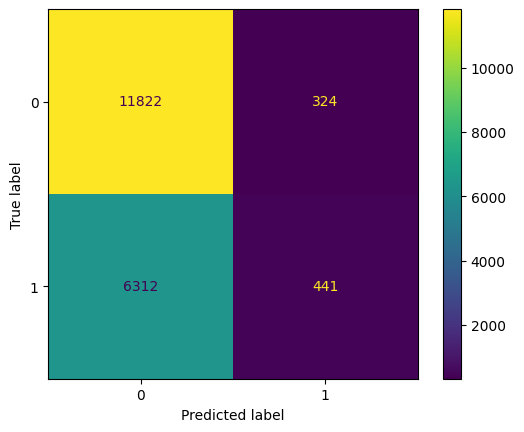

In [18]:
ConfusionMatrixDisplay(confusion_matrix(test_preds_df.truth, test_preds_df.binary_pred)).plot()

In [19]:
evaluate_df(test_preds_df, 'full dataframe')


full dataframe ----------------------------------------
N=18899
accuracy:	0.649
auroc:		0.629
f1 score:	0.117
sensitivity:	0.065
specificity:	0.973


In [31]:
# artificially rebalance our classes to see how it affects results
neg_subset_df = test_preds_df[test_preds_df.truth == 0]
pos_subset_df = test_preds_df[test_preds_df.truth == 1].sample(100)

evaluate_df(pd.concat([neg_subset_df, pos_subset_df]), 'rebalanced dataframe')


rebalanced dataframe ----------------------------------------
N=12246
accuracy:	0.966
auroc:		0.636
f1 score:	0.019
sensitivity:	0.040
specificity:	0.973


---
# 2.0 Subgroup Evaluation

## 2.1 Feature Cleaning

### 2.1.1 Patient Race and Ethnicity

In [20]:
def bin_ethnicity(df):
    # bin ethnicity
    df['ETHNIC_GROUP_DESC'].str.strip()
    df.loc[:, 'Ethnicity'] = 'Unknown'
    not_hispanic_list = ['Non-Hispanic or Latino', 'Non-Hispanic~Unknown', 'Unknown~Non-Hispanic']
    df.loc[df['ETHNIC_GROUP_DESC'].isin(not_hispanic_list), 'Ethnicity'] = 'Not Hispanic or Latino'

    hispanic_list = ['Hispanic or Latino', 'Unknown~Hispanic']
    df.loc[df['ETHNIC_GROUP_DESC'].isin(hispanic_list), 'Ethnicity'] = 'Hispanic or Latino'
    return df

def bin_race(df):
    # bin race
    df['ETHNICITY_DESC'].str.strip()
    df.loc[:, 'Race'] = 'Other'
    df.loc[df['ETHNICITY_DESC'] == "African American  or Black", 'Race'] = 'Black'
    df.loc[df['ETHNICITY_DESC'] == "Caucasian or White", 'Race'] = 'White'
    df.loc[df['ETHNICITY_DESC'] == "Asian", 'Race'] = 'Asian'
    df.loc[df['ETHNICITY_DESC'] == "Unknown, Unavailable or Unreported", 'Race'] = 'Unknown'
    return df

test_preds_df = bin_ethnicity(test_preds_df)
test_preds_df = bin_race(test_preds_df)

### 2.1.2 Imaging Findings

In [21]:
def extract_findings(row):
    # output imaging features coded as either 0: absent or 1: present
    findings_dict = {
        'mass': 0,
        'asymmetry': 0,
        'arch_distortion': 0,
        'calcification': 0
    }

    if (row['massshape'] in ['G', 'R', 'O', 'X', 'N', 'Y', 'D', 'L']) or\
    (row['massmargin'] in ['D', 'U', 'M', 'I', 'S']) or\
    (row['massdens'] in ['+', '-', '=']):
        findings_dict['mass'] = 1

    if row['massshape'] in ['T', 'B', 'S', 'F', 'V']:
        findings_dict['asymmetry'] = 1

    if row['massshape']in ['Q', 'A']:
        findings_dict['arch_distortion'] = 1

    if (row['calcdistri'] is not np.nan) or\
    (row['calcfind'] is not np.nan) or\
    (row['calcnumber'] != 0):
        findings_dict['calcification'] = 1

    return findings_dict

test_preds_df[['mass', 'asymmetry', 'arch_distortion', 'calcification']] = test_preds_df.apply(
    extract_findings, 
    axis='columns', 
    result_type='expand'
)

### 2.1.3 Patient Age Bins

In [22]:
def bin_feature(df, feature, bin_interval_dict):
    # get binned feature name
    binned_feature = f"{feature}_bins"

    # initialize binned feature
    df[binned_feature] = 'nan'

    # iterate over intervals defined in the interval dictionary
    for level_name, (interval_min, interval_max) in bin_interval_dict.items():
        df_mask = (df[feature] >= interval_min) & (df[feature] < interval_max)
        df.loc[df_mask, binned_feature] = level_name

    return df

bin_intervals = {
    '<40': (0, 40),
    '40-60': (40, 60),
    '>=60': (60, 200)
}

test_preds_df = bin_feature(test_preds_df, 'age_at_study', bin_intervals)

## 2.2 Univariate Evaluation
The simplest univariate evaluation most people do is to stratify model performance by some demographic category.


Race == White ----------------------------------------
N=7476

Race == Black ----------------------------------------
N=8089

Race == Unknown ----------------------------------------
N=1793

Race == Asian ----------------------------------------
N=1189

Race == Other ----------------------------------------
N=352


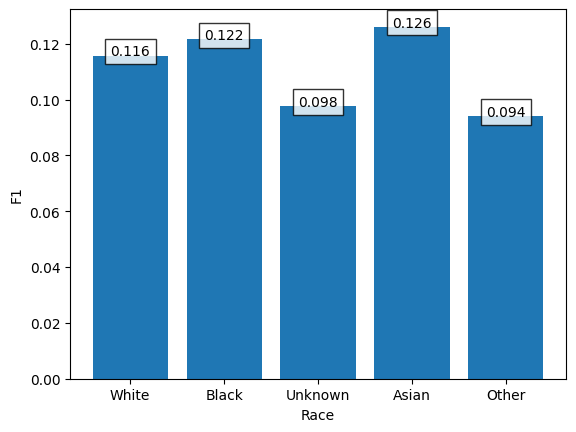

In [23]:
import matplotlib.pyplot as plt
import math

stratify_feature = 'tissueden'
target_metric = 'accuracy'

def univariate_analysis(df, stratify_feature, target_metric):
    feature_levels = df[stratify_feature].unique().tolist()
    feature_levels = [f for f in feature_levels if str(f) != 'nan']
    
    output_dict = dict()
    
    for current_level in feature_levels:
        subset_df = df[df[stratify_feature] == current_level]
        level_dict = evaluate_df(subset_df, f'{stratify_feature} == {current_level}', return_dict=True)
        output_dict[current_level] = level_dict
    
    metric_dict = {feature_level:level_dict[target_metric] for feature_level,level_dict in output_dict.items()}
    
    # function to add value labels
    def addlabels(x,y):
        for i in range(len(x)):
            plt.text(i, y[i], format(y[i], '.3f'), ha = 'center',
                 bbox = dict(facecolor = 'white', alpha =.8))
    
    plt.xlabel(stratify_feature)
    plt.ylabel(target_metric.title())
    
    x = list(metric_dict.keys())
    y = list(metric_dict.values())
    
    plt.bar([str(i) for i in x], y)
    addlabels(x, y)
    plt.show()

univariate_analysis(test_preds_df, stratify_feature='Race', target_metric='f1')

> ## Question
>
> **What are some problems we could run into with a univariate approach?**

![confounding_basics](images/confounding_basics.png)

## 2.3 Multivariate Evaluation
Multivariate evaluation is much more complex (talk to a statistician!!), but it can be more effective at identifying which features are associated with performance differences and allows confounders to be accounted for.

In [29]:
import statsmodels.api as sm

test_preds_df['tissueden'] = test_preds_df.tissueden.astype(str)
test_preds_df['incorrect'] = test_preds_df.truth != test_preds_df.binary_pred

# lets use the generalized linear model from the statsmodels package to check this
# 
sm.formula.glm("incorrect ~ Race + tissueden", family=sm.families.Binomial(), data=test_preds_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Generalized Linear Model Regression Results                            
===================================================================================================
Dep. Variable:     ['incorrect[False]', 'incorrect[True]']   No. Observations:                18834
Model:                                                 GLM   Df Residuals:                    18825
Model Family:                                     Binomial   Df Model:                            8
Link Function:                                       Logit   Scale:                          1.0000
Method:                                               IRLS   Log-Likelihood:                -12063.
Date:                                     Wed, 21 Aug 2024   Deviance:                       24126.
Time:                                             18:32:09   Pearson chi2:                 1.88e+04
No. Iterations:                                         21   Pseudo R-squ. (CS):            0.01471
Covariance Type:                                 nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.2922      0.081     15.999      0.000       1.134       1.450
Race[T.Black]       -0.3968      0.067     -5.891      0.000      -0.529      -0.265
Race[T.Other]       -0.5433      0.125     -4.352      0.000      -0.788      -0.299
Race[T.Unknown]      0.1060      0.082      1.299      0.194      -0.054       0.266
Race[T.White]       -0.1014      0.067     -1.503      0.133      -0.234       0.031
tissueden[T.2.0]    -0.3871      0.054     -7.154      0.000      -0.493      -0.281
tissueden[T.3.0]    -0.6528      0.054    -12.002      0.000      -0.759      -0.546
tissueden[T.4.0]    -0.4994      0.086     -5.837      0.000      -0.667      -0.332
tissueden[T.5.0]    21.6707   1.82e+04      0.001      0.999   -3.57e+04    3.57e+04
====================================================================================
"""

In [30]:
sm.formula.glm(
    "fn ~ mass + asymmetry + arch_distortion + calcification", 
    family=sm.families.Binomial(), 
    data=test_preds_df
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     fn   No. Observations:                18899
Model:                            GLM   Df Residuals:                    18894
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6166.2
Date:                Wed, 21 Aug 2024   Deviance:                       12332.
Time:                        18:33:07   Pearson chi2:                 7.12e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4628
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -2.4049      0.032    -74.424      0.000      -2.468      -2.342
mass                2.9288      0.072     40.523      0.000       2.787       3.070
asymmetry           4.5975      0.069     66.258      0.000       4.461       4.733
arch_distortion     5.1504      0.233     22.113      0.000       4.694       5.607
calcification       3.7571      0.068     55.275      0.000       3.624       3.890
===================================================================================
"""

---
# 3.0 Modeling Best Practices

## "All models are wrong, but some are useful" 
**George E. P. Box**

### How can we maximize model utility?

---

### [Modeling Scenario Activity]
For each scenario, consider the following:
1. Could this approach pose any problems?
2. If so, how can we address them?

### Scenarios:
1. You're training a classification model and are building your data pipeline to preprocess and transform your images. You pool your train, validation, and test sets then calculate their mean and standard deviation to normalize all of your images. You further select random cropping, random flipping, gaussian blur, and color shifting transformations and apply them to all of your images in your sets.
   
2. You're working on an abnormality localization (segmentation) model, so you choose to first pre-train your model on patch images to form the backbone (encoder) of your model. You then plan to randomly split your full dataset into train/val/test partitions and finetune your model on the full images.
   
3. You're working on a cancer classification model. You tune its hyperparameters to find the set that maximizes your test performance metrics, then you try multiple random seeds and report the maximum test performance you achieved.

   
4. You're training a classification model to identify a specific type of rare cancer. Your dataset is heavily imbalanced, so you undersample your majority class and re-balance your data so you have a 50%/50% positive/negative split. You train, validate, and evaluate your model on this data. You achieve impressive performance on your data so you recommend deployment in a clinical setting.